<a href="https://colab.research.google.com/github/mnassar/py2vpy3xai/blob/main/py2vpy3_Model_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@author: mnassar

Code for a model generation

Modified Malconv Neural Network Architecture

In [ ]:
import tensorflow as tf

from keras.models import Model
from keras.layers import Dense, Embedding, Conv1D, multiply, GlobalMaxPool1D, Input, Activation
from keras import regularizers

MAX_LEN = 100
WIN_SIZE = 5
NB_FILTERS = 64

def Malconv(max_len=MAX_LEN, win_size=WIN_SIZE, vocab_size=256):
    inp = Input((max_len,))
    emb = Embedding(vocab_size, 8)(inp)
    conv1 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same')(emb)
    conv2 = Conv1D(kernel_size=(win_size), filters=NB_FILTERS, strides=(1), padding='same')(emb)
    a = Activation('sigmoid', name='sigmoid')(conv2)
    mul = multiply([conv1, a])
    a = Activation('relu', name='relu', activity_regularizer=regularizers.L1(0.01))(mul)
    p = GlobalMaxPool1D()(a)
    d = Dense(8)(p)
    out = Dense(1, activation='sigmoid')(d)
    return Model(inp, out)


m = Malconv(win_size=10)
m._name = "MM1_80k_Win5_NF64"
m.summary()

Model: "MM1_80k_Win5_NF64"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 8)               2048      ['input_2[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 100, 64)              5184      ['embedding_1[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)           (None, 100, 64)              5184      ['embedding_1[0][0]']         
                                                                                  

Read and preprocess the data

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import numpy as np
import pandas as pd

df = pd.read_csv("dataset10k.csv")
df["class"].unique()

array([3, 2])

In [ ]:
# clean NAN lines
df = df.drop ( df[df["lines of code"].isnull()].index )
df[df["lines of code"].isnull()]

,lines of code,class,print(,__future__,xrange,range,"u""",print,unicode(,__next__(,raw_input(,explanation


In [ ]:
x_train = [ bytearray(line, encoding="utf-8") for line in df["lines of code"] ]
y_train = np.array ( df["class"] - 2 )

x_train_padded = pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
x_train_padded.shape

(9833, 100)

In [ ]:
def data_generator(x_data, y_data, batch_size, shuffle):
    idx = np.arange(len(x_data))
    if shuffle:
        np.random.shuffle(idx)
    nb_batches = len(x_data) // batch_size + 1
    batches = [ idx [ range ( batch_size * i, min(len(x_data), batch_size * (i+1)) ) ]
               for i in range(nb_batches) ]
    while True:
        for i in batches:
            xx = x_data[i]
            yy = y_data[i]
            yield (xx, yy)


In [ ]:
d = data_generator(x_train_padded, y_train, 64, shuffle=True)
next(d)[0].shape

(64, 100)

Training

Epoch 1/20
615/615 [==============================] - 13s 14ms/step - loss: 0.3585 - acc: 0.8627
Epoch 2/20
615/615 [==============================] - 3s 6ms/step - loss: 0.1373 - acc: 0.9597
Epoch 3/20
615/615 [==============================] - 4s 6ms/step - loss: 0.1084 - acc: 0.9665
Epoch 4/20
615/615 [==============================] - 4s 6ms/step - loss: 0.0841 - acc: 0.9766
Epoch 5/20
615/615 [==============================] - 4s 6ms/step - loss: 0.0712 - acc: 0.9795
Epoch 6/20
615/615 [==============================] - 4s 7ms/step - loss: 0.0620 - acc: 0.9823
Epoch 7/20
615/615 [==============================] - 4s 6ms/step - loss: 0.0564 - acc: 0.9839
Epoch 8/20
615/615 [==============================] - 3s 6ms/step - loss: 0.0505 - acc: 0.9865
Epoch 9/20
615/615 [==============================] - 4s 6ms/step - loss: 0.0450 - acc: 0.9889
Epoch 10/20
615/615 [==============================] - 4s 7ms/step - loss: 0.0421 - acc: 0.9901
Epoch 11/20
615/615 [==========================

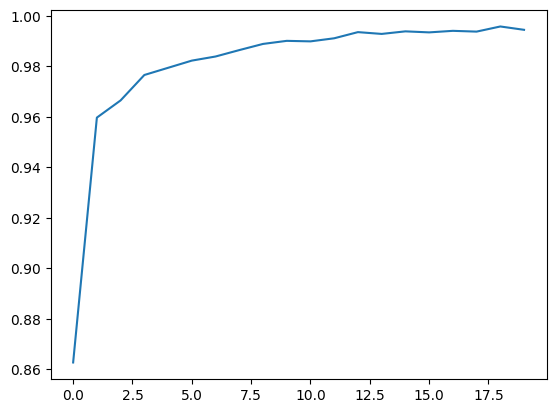

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.losses import BinaryCrossentropy
from os.path import join
import matplotlib.pyplot as plt

BATCH_SIZE = 16
NB_EPOCHS = 20


# ear = EarlyStopping(monitor='val_acc', patience=5)
# mcp = ModelCheckpoint(filepath='malconv.keras')

m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = m.fit(
    data_generator(x_train_padded, y_train, BATCH_SIZE, shuffle=True),
    steps_per_epoch=len(x_train)//BATCH_SIZE + 1,
    epochs=NB_EPOCHS,
    verbose=1,
    # callbacks=[mcp],
    )

plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])



In [ ]:
m.save(m._name + ".keras")

In [ ]:
from keras import models
m = models.load_model(m._name + '.keras')
m.summary()
